# Basic text classification

here demonstrates the text classification.


In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# sentiment analysis

Here this notebook trains a sentiment analysis model to classfiy movie review as positive or negative review on the basis of text review.

This method is an example of binary-or two-class-classification

# Download and explore the IMDB data set

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 7s 0us/step


In [ ]:
os.listdir(dataset_dir)

['test', 'imdb.vocab', 'README', 'imdbEr.txt', 'train']

In [ ]:
train_dir = os.path.join(dataset_dir,  'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'urls_neg.txt',
 'neg',
 'unsup',
 'urls_pos.txt',
 'pos',
 'labeledBow.feat',
 'unsupBow.feat']

The aclImdb/train/pos and aclImdb/train/neg directores contain many text files, each which is a single movie review.

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')

with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the data set

We will load the data off disk and prepare it into a format suitable for training.

 To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```


To prepare a dataset for binary classification need two floders on disk,
corresponding to class_a and class_b.

In [ ]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Use the text_dataset_from_directory utility to create a labeled tf.data.Dataset.
The best practice to divide your dataset 3 parts.


1.   Train
2.   Validation
3.   Test

Create a validation set using an 80:20 spilt of the training data by using the validation_split argument below.




In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Here some reivew cotain raw text like HTMl tags<br/>

The labels are 0 or 1 for positive and negative movie review.

In [ ]:
print("Label 0 shows", raw_train_ds.class_names[0])
print("Label 1 shows", raw_train_ds.class_names[1])

Label 0 shows neg
Label 1 shows pos


using of the validation_split and subset arguements, make sure to either specify a random seed so that the validation and training splits have no overlap. 

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


# Prepare the dataset for training

Now we will work Standardize, Tokenize and Vectorize the data using helpful 
preprocessing.TextVectorization layer.

Standardize : Preprocessing text, typically to remove punctuatuation or HTML elements to simplify the dataset.

Tokenize: splitting strings into tokens(splitting a sentance into individual words, by spiltting on whitespace).

Vectorize: Converting tokens into numbers so they can be fed into a neural network.




In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Explicit maximum sequence_length which will cause the layer to pad or truncate sequences to exactly sequences_length values.

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [ ]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


Nearly ready to train your model.As a final preprocessing step, you will apply the TextVectorization layer, created earlier to the train, validation and test dataset.

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configure the dataset for performance

2 methods are important methods

1. .cache(): keeps data in memory after it's loaded off disk

2. .prefetch(): overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Create the model

create neural network

In [ ]:
embedding_dim = 16

In [ ]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


# The layers are stacked sequentially to bulid the classifer.

1. The first layer is an Embedding layer.In this layers takes the integer-encoded review and looks up an embedding vector for each word-index.
These vectors are learned as the model trains.
The vecotrs add a dimension to the ouput array.The resulting dimension are: batch, sequence, emnbedding.

2. GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension.

3. This fixed-length output vector is piped through a fully-connected layer.

4. The last layers is densely connected with a single output node.



# Loss function and optimizer

In training a model needs a loss function and an optimizer.

configure the model to use an optimizer and loss function.

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Train the model

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 12s 19ms/step - loss: 0.6812 - binary_accuracy: 0.6216 - val_loss: 0.6115 - val_binary_accuracy: 0.7750
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5766 - binary_accuracy: 0.7886 - val_loss: 0.4954 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 5s 7ms/step - loss: 0.4630 - binary_accuracy: 0.8379 - val_loss: 0.4184 - val_binary_accuracy: 0.8478
Epoch 4/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3900 - binary_accuracy: 0.8614 - val_loss: 0.3727 - val_binary_accuracy: 0.8608
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3434 - binary_accuracy: 0.8763 - val_loss: 0.3442 - val_binary_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3098 - binary_accuracy: 0.8873 - val_loss: 0.3252 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

# Evaluate the model


In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)# here returning 2 values 

782/782 [==============================] - 10s 13ms/step - loss: 0.3097 - binary_accuracy: 0.8734
Loss:  0.30966487526893616
Accuracy:  0.8733999729156494


# Create a plot of accuracy and loss over time

In [ ]:
history_dict = history.history
history_dict.keys()#Here there are four entries

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

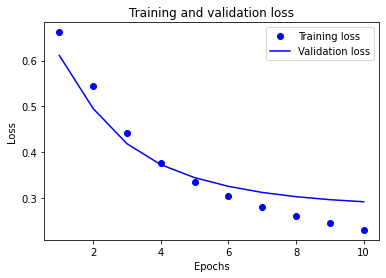

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

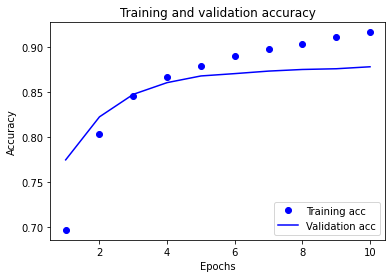

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot example of overfitting, the model performs better on the training data than it does on data it has never seen before.

After this points the model over-optimizes and leadrns representations specific to the traininig data that do not generalize to test data.

# Export thr model

create a new model using the weights and trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3066 - accuracy: 0.8774
0.8733999729156494


In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.64045745],
       [0.46386176],
       [0.3798085 ]], dtype=float32)